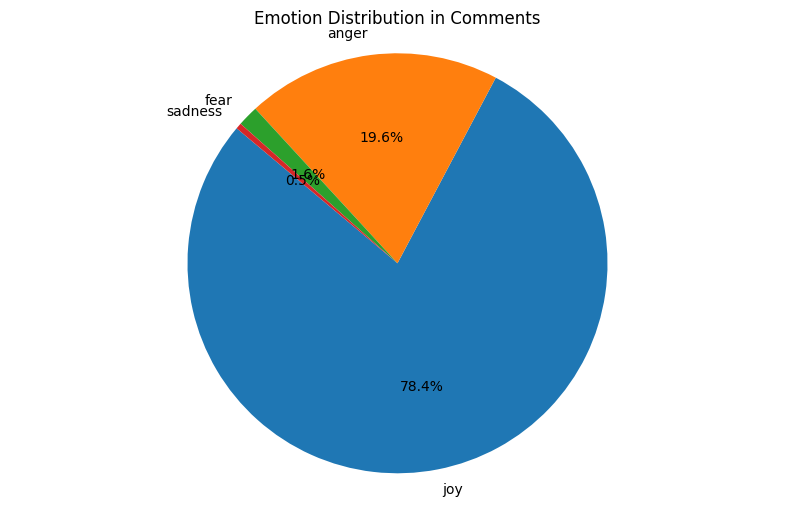

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
#import en_core_web_sm
#from spacy.matcher import Matcher
#from transformers import pipeline
from fpdf import FPDF

# uzycie pre-trained language model hosted on the Hugging Face Model Hub(bhadresh-savani/distilbert-base-uncased-emotion) in order to detect sentiment
emotion_model = 'bhadresh-savani/distilbert-base-uncased-emotion'
emotion_pipeline = pipeline('sentiment-analysis', model=emotion_model, top_k=1)


#nlp = en_core_web_sm.load()
#matcher = Matcher(nlp.vocab)

# loading the comments content and review rating (used in addition to the graph to be able to compare how the rating was given in relation to the emotions in the comments)
def load_data(num_comments):
    df = pd.read_csv('order_reviews.csv', nrows=num_comments)
    #removing empty values from these two columns
    df = df.dropna(subset=['review_comment_message', 'review_score'])
    # assignment of reviews to positive negative and neutral
    df['sentiment'] = df['review_score'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))
    return df

# Function to be found in the price text; it handles the input for a single comment and then applied to all values in the comments column of the csv file.
def extract_prices(text):
    prices_found = []
    words = text.split()
    for i, word in enumerate(words):
        # checking the occurrence of the currency sign before and after and checking numbers with commas and full stops detects 100.00 as a number and sentences with commas do not
        if word.replace('.', '', 1).isdigit() or word.replace(',', '', 1).isdigit()  :
            # I noticed that in the Portuguese comments the currency is often prefixed with R$ the $ itself should work but I wasn't sure if it did in every case so I added it
            if i > 0 and words[i - 1] in {'$', 'USD', 'EUR', 'R$', '€', 'dollars', 'euros'}:
                prices_found.append(f"{words[i - 1]} {word}")
            if i < len(words) - 1 and words[i + 1] in {'$', 'USD', 'EUR', 'R$', '€', 'dollars', 'euros'}:
                prices_found.append(f"{word} {words[i + 1]}")
                # for price type R$20
        elif word[0] in {'$', 'USD', 'EUR', 'R$', '€', 'dollars', 'euros'} and word[1:].replace('.', '', 1).isdigit():
            prices_found.append(word)
            
    return prices_found


#a simple function that returns a message and found prices based on the price check function for a single comment in the gui
def check_price_in_comment():
    comment_text = comment_entry.get("1.0", tk.END).strip()
    if comment_text:
        prices_found = extract_prices(comment_text)
        if prices_found:
            messagebox.showinfo("Price Detection", "Price detected in the comment."+str(prices_found))
        else:
            messagebox.showinfo("Price Detection", "No price detected in the comment.")
    else:
        messagebox.showerror("Error", "Please enter a comment.")

# Function for checking what emotion is in the text
def classify_emotion(texts):
    emotion_results = emotion_pipeline(texts)
    emotions = [max(result, key=lambda x: x['score'])['label'] for result in emotion_results]
    return emotions

# Function drawing a graph for product evaluation
def plot_ratings(ax, df):
    ax.clear()
    emotions_data = df['sentiment'].value_counts()
    labels = emotions_data.index
    sizes = emotions_data.values
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')
    ax.set_title('Product ratings')

# Function for drawing a price chart % how many comments had a price in them
def plot_price_comments(ax, df):
    ax.clear()
    df['prices_found'] = df['review_comment_message'].apply(extract_prices)
    comments_with_prices = df[df['prices_found'].apply(len) > 0]
    ax.bar(['With Prices', 'Without Prices'], [len(comments_with_prices), len(df) - len(comments_with_prices)])
    ax.set_title('Percentage of Comments with Prices Detected')
    ax.set_xlabel('Comments')
    ax.set_ylabel('Number of Comments')
    ax.set_ylim(0, len(df))
    percentage_with_prices = len(comments_with_prices) / len(df) * 100
    ax.text(0, len(comments_with_prices) + 1, f"{percentage_with_prices:.2f}%")

# Function for drawing an emotion graph
def plot_emotion(ax, df):
    ax.clear()
    emotion_results = classify_emotion(df['review_comment_message'].dropna().tolist())
    emotion_data = pd.Series(emotion_results).value_counts()
    labels = emotion_data.index
    sizes = emotion_data.values
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')
    ax.set_title('Emotion Distribution in Comments')

# Function chart listing how many prices in the commentary have been detected
def plot_price_detection_nlp(ax, df):
    ax.clear()
    df['num_prices_detected'] = df['review_comment_message'].apply(lambda x: len(extract_prices(x)))
    bins = range(0, max(df['num_prices_detected']) + 2, 1)
    ax.hist(df['num_prices_detected'], bins=bins, edgecolor='black', align='left')
    ax.set_xticks(bins[:-1])
    ax.set_xlabel('Number of Prices Detected')
    ax.set_ylabel('Number of Comments')
    ax.set_title('Distribution of Comments by Number of Prices Detected')

# Function empty placeholder chart into gui
def plot_initial(ax):
    ax.clear()
    ax.set_title('Select a plot type to display the data.')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

# Function auxiliary to the % value
def update_percentage_with_prices(ax, df):
    comments_with_prices = df[df['prices_found'].apply(len) > 0]
    percentage_with_prices = len(comments_with_prices) / len(df) * 100
    ax.text(0, len(comments_with_prices) + 1, f"{percentage_with_prices:.2f}%")

# Function generating graphs on the basis of a selected list in the gui
def generate_plot():
    plot_type = plot_var.get()
    num_comments = int(num_comments_var.get())

    # loading the number for which amount of data we want to do it I have limited it for the sake of waiting times for the chart 
    df = load_data(num_comments)

    # clearing the graph before drawing the next one (graphs overlapped)
    fig.clear()
    ax = fig.add_subplot(111)

    if plot_type == "Ratings Distribution":
        plot_ratings(ax, df)
    elif plot_type == "Comments with Prices":
        plot_price_comments(ax, df)
        update_percentage_with_prices(ax, df)  
    elif plot_type == "Emotion Distribution":
        plot_emotion(ax, df)
    elif plot_type == "Price Detection Distribution":
        plot_price_detection_nlp(ax, df)

    canvas.draw()

# Function generating reports (not very nice) in this function you can play with to make more attractive reports and to include more data 
def generate_report():
    plot_type = plot_var.get()
    num_comments = int(num_comments_var.get())
    df = load_data(num_comments)
    fig.clear()
    ax = fig.add_subplot(111)

    if plot_type == "Ratings Distribution":
        plot_ratings(ax, df)
    elif plot_type == "Comments with Prices":
        plot_price_comments(ax, df)
    elif plot_type == "Emotion Distribution":
        plot_emotion(ax, df)
    elif plot_type == "Price Detection Distribution":
        plot_price_detection_nlp(ax, df)

    # auxiliary saving of chart to png file
    plot_filename = 'plot.png'
    fig.savefig(plot_filename)

    # creation of a pdf file
    pdf = FPDF()
    pdf.add_page()

    # setting the page background
    pdf.set_fill_color(200, 200, 200)  
    pdf.rect(0, 0, 210, 297, 'F')  

    # Tytul report dependent on choice
    pdf.set_font("Arial", size=24, style='B')
    pdf.set_text_color(0, 0, 128)  
    pdf.cell(200, 20, txt=f"Report for {plot_type}", ln=True, align='C')

    # adding a saved graph to the report
    pdf.image(plot_filename, x=10, y=30, w=190)

    pdf.set_font("Arial", size=12)
    pdf.set_text_color(0, 0, 0)  

    pdf.ln(140) 
    # data tables for the report can be customised for different 
    if plot_type == "Ratings Distribution":
        pdf.cell(200, 10, txt="Ratings Distribution Table:", ln=True, align='L')
        emotions_data = df['sentiment'].value_counts()
        pdf.cell(50, 10, "Emotion", 1, 0, 'C')
        pdf.cell(50, 10, "Count", 1, 1, 'C')
        for label, value in emotions_data.items():
            pdf.cell(50, 10, label, 1, 0, 'C')
            pdf.cell(50, 10, str(value), 1, 1, 'C')

    elif plot_type == "Comments with Prices":
        comments_with_prices = df[df['prices_found'].apply(len) > 0]
        percentage_with_prices = len(comments_with_prices) / len(df) * 100
        pdf.cell(200, 10, txt="Comments with Prices Table:", ln=True, align='L')
        pdf.cell(100, 10, f"With Prices: {len(comments_with_prices)}", ln=True, align='L')
        pdf.cell(100, 10, f"Without Prices: {len(df) - len(comments_with_prices)}", ln=True, align='L')
        pdf.cell(100, 10, f"Percentage with Prices: {percentage_with_prices:.2f}%", ln=True, align='L')

    elif plot_type == "Emotion Distribution":
        pdf.cell(200, 10, txt="Emotion Distribution Table:", ln=True, align='L')
        emotion_results = classify_emotion(df['review_comment_message'].dropna().tolist())
        emotion_data = pd.Series(emotion_results).value_counts()
        pdf.cell(50, 10, "Emotion", 1, 0, 'C')
        pdf.cell(50, 10, "Count", 1, 1, 'C')
        for label, value in emotion_data.items():
            pdf.cell(50, 10, label, 1, 0, 'C')
            pdf.cell(50, 10, str(value), 1, 1, 'C')

    elif plot_type == "Price Detection Distribution":
        pdf.cell(200, 10, txt="Price Detection DistributionTable:", ln=True, align='L')
        df['num_prices_detected'] = df['review_comment_message'].apply(lambda x: len(extract_prices(x)))
        pdf.cell(100, 10, "Number of Prices Detected", 1, 0, 'C')
        pdf.cell(100, 10, "Count", 1, 1, 'C')
        for num_prices, count in df['num_prices_detected'].value_counts().items():
            pdf.cell(100, 10, str(num_prices), 1, 0, 'C')
            pdf.cell(100, 10, str(count), 1, 1, 'C')

    # saving the report
    pdf.output('report.pdf')


# GUI 
root = tk.Tk()
root.title("Sentiment and Price Analysis")

# gui window
main_frame = ttk.Frame(root, padding="20")
main_frame.grid(column=0, row=0, sticky=(tk.W, tk.E, tk.N, tk.S))

# CHOICE OF CHART
plot_label = ttk.Label(main_frame, text="Select Plot Type:")
plot_label.grid(column=0, row=0, sticky=tk.W)
plot_var = tk.StringVar()
plot_combobox = ttk.Combobox(main_frame, textvariable=plot_var, values=["Ratings Distribution", "Comments with Prices", "Emotion Distribution", "Price Detection Distribution"], state='readonly')
plot_combobox.set("Emotion Distribution") 
plot_combobox.grid(column=1, row=0)

num_comments_label = ttk.Label(main_frame, text="Select Number of Comments:")
num_comments_label.grid(column=0, row=1, sticky=tk.W)
num_comments_var = tk.StringVar()
num_comments_combobox = ttk.Combobox(main_frame, textvariable=num_comments_var, values=["100", "1000", "10000", "100000"], state='readonly')
num_comments_combobox.grid(column=1, row=1)
num_comments_combobox.set("1000") 

plot_button = ttk.Button(main_frame, text="Generate Plot", command=generate_plot)
plot_button.grid(column=0, row=2, columnspan=2, pady=(10, 0))

# report generation
report_button = ttk.Button(main_frame, text="Generate Report", command=generate_report)
report_button.grid(column=0, row=3, columnspan=2, pady=(10, 0))
price_detection_label = ttk.Label(main_frame, text="Price Detection in Single Comment:")
price_detection_label.grid(column=2, row=0, sticky=tk.W, padx=(30, 30), pady=(0, 10))
# additional input to check if a single comment has a price
comment_entry = tk.Text(main_frame, height=4, width=50)
comment_entry.grid(column=2, row=1, padx=(40, 0), pady=(0, 10))
check_price_button = ttk.Button(main_frame, text="Check Price Detection", command=check_price_in_comment)
check_price_button.grid(column=2, row=2, pady=(40, 0))

# graph in gui
fig, ax = plt.subplots(figsize=(10, 6))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().grid(column=0, row=4, columnspan=2, sticky=(tk.W, tk.E, tk.N, tk.S))

# placeholder for the chart
plot_initial(ax)
canvas.draw()

root.mainloop()


In [114]:
print("hellp")

hellp
